# Course Four: Build a Regressor

Expected time to complete: XX minutes

## Goal of this Course
During this course we will build a regressor to forecast the minutes watched within the last two-week group.

This course is split into the following parts:
- <a href='#context'>Context</a> 
- <a href='#model_evaluation'>Model Evaluation</a> 
- <a href='#baseline_forecast'>Baseline Forecast</a>
    - <a href='#load_data'>Load the Data</a>
    - <a href='#define_baseline'>Define a Baseline</a>


- <a href='#linear_reg'>Linear Regression</a>
    - <a href='#model_training'>Model Training</a>
    - <a href='#out_sample_error'>Out-of-Sample Error</a>
    - <a href='#in_sample_error'>In-Sample Error and Estimated Coefficients</a>


- <a href='#ridge_reg'>Ridge Regression</a>
    - <a href='#model_training2'>Model Training and Hyperparameters Tuning</a>
    - <a href='#best_ridge_reg'>Best Ridge Regression</a>


- <a href='#lasso_reg'>Lasso Regression</a>
    - <a href='#model_training3'>Model Training and Hyperparameters Tuning</a>
    - <a href='#best_lasso_reg'>Best Lasso Regression</a>

<a id='context'></a>
# Context
In the previous tutorial we explained how the training process works and how to evaluate our models in the classification framework. We built few models to predict whether a user will consume content on the last two-week group based on his past behaviour on the 7 two-week groups before. 

Forecasting if a user will consume content is very usefull. It allows for example to focus our efforts on the ones who are not likely to come back.

The users who are likely to come back within the last two-week period might also have different levels of engagement. Understanding to what extent they will consume content is key for the BBC to personnalise their experience with the product.   

In order to forecast the minutes watched within the next two-week group we will first define our evaluation metric. As for the classifier, we will then try different models and compare their performances to a baseline. 


<a id='model_evaluation'></a>
# Model Evaluation

For regressors, the evaluation of the model is less straightforward and is usually based upon the average residual between the actual observations and the model predictions. 

__Root mean squared error__ (RMSE) and __mean absolute error__ (MAE) are two commonly used examples of these. Once we have a representation of the error produced by the model we can compare that error with the error of the most simple model of the data (usually the mean). This statistic is known as the coefficient of determination or __R-squared__ and represents the part of variability the model managed to get.

<a id='baseline_forecast'></a>
# Baseline Forecast

<a id='load_data'></a>
## Load the Data
The first thing to do is to get our data back and make sure we have the correct one.

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [2]:
# We put both target arrays (regression and classification) in the same txt file
# As both target arrays have the same size we just need to split it it two
# and get the correct part for the prediction task
target = np.split(np.loadtxt('target.txt'), 2)[0].flatten()
features = pd.read_csv('features.csv')

# User id as index
features = features.set_index('user_id')

In [3]:
# Make sure we have the right input database
features.head()

,tw_lag7_watched,tw_lag6_watched,tw_lag5_watched,tw_lag4_watched,tw_lag3_watched,tw_lag2_watched,tw_lag1_watched,average_completion,total_sessions,num_genre,...,most_weekday_weekday_1,most_weekday_weekday_2,most_weekday_weekday_3,most_weekday_weekday_4,most_weekday_weekday_5,most_weekday_weekday_6,most_timeday_Afternoon,most_timeday_Evening,most_timeday_Morning,most_timeday_Night
user_id,,,,,,,,,,,,,,,,,,,,,
0001c6,16.679200,0.000000,0.0000,0.000000,0.000000,0.152550,0.000000,0.371496,2,1,...,1,0,0,0,0,0,0,1,0,0
000c1a,0.162867,0.147467,107.0984,145.686233,2.286283,100.487767,132.432083,0.233136,28,5,...,0,0,1,0,0,0,0,0,1,0
001c53,1.866300,0.000000,0.0000,0.000000,1.309867,0.000000,0.000000,0.489419,3,2,...,0,1,0,0,0,0,0,0,1,0
001d44,0.000000,0.000000,0.0000,14.547700,0.000000,0.000000,0.248017,0.058203,2,2,...,0,0,0,0,0,1,0,0,1,0
002b2e,291.477033,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.228233,17,5,...,0,1,0,0,0,0,0,1,0,0


In [4]:
# Make sure we have the right output
target[:10]

array([  1.44833333e-01,   3.18047633e+02,   1.98035000e+00,
         1.00590667e+01,   0.00000000e+00,   4.79261667e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00])

<a id='define_baseline'></a>
## Define a Baseline

As mentionned in the last course we should have a baseline to compare the performance of our models with. Here as we are forecasting a quantitative variable, a simple model is for example the one that predicts a constant value like 0, or the mean or the median we do observe in our data. 

Note as well that by default `scikit` _maximises_ metrics and error metrics have been implemented as a negative number within the scoring function. We therefore negate the errors we get to make them comparable and are looking for those models that maximise it.

In [5]:
# Create a baseline to compare our results to (mean and median minutes watched and 0)
mean=np.mean(target)
median=np.median(target)

mean_forecast=[mean]*len(target)
median_forecast=[median]*len(target)
zero_forecast=[0]*len(target)

In [6]:
print("Mean: "+str(mean))
print("Median: "+str(median))

Mean: 75.9168097123
Median: 0.0


The median is null, meaning than more than half of our users don't consume content on iPlayer within the last two weeks.

There is no need to consider the constant model equal to 0 as a baseline here (same as the median one).

In [17]:
# Compute the errors for these different baseline
from sklearn import metrics
print("Score if we forecast the mean:",
      -metrics.mean_absolute_error(target,mean_forecast))
print("Score if we forecast the median:",
      -metrics.mean_absolute_error(target,median_forecast))

Score if we forecast the mean: -115.319756974
Score if we forecast the median: -75.9168097123


We will now try different kind of regressions. These models are great for business insights as we can __quantify the impact__ of our input variables on the target one.

<a id='linear_reg'></a>
# Linear Regression

The easiest way to relate our output variable to our input ones is to use a __linear combination__.

A linear regression decomposes the observed output in an additive way such that the coefficients we estimate in the training process can be interpreted as the impact of a given input all other things being equal (AOTBE). For more details see: https://en.wikipedia.org/wiki/Linear_regression

And for the `scikit learn` documentation: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [8]:
# Let's build a simple regression
from sklearn import linear_model

# We will use cross validation, so import helper functions for this
from sklearn.model_selection import cross_val_score, cross_val_predict

# Plots
from matplotlib import pyplot as plt 

<a id='model_training'></a>
## Model Training

With this kind of modelling there is no hyperparameter to tune. Indeed, the model only has to evaluate the _contribution_ of each input variable to the linear combination.  

The `cross_val_predicts` functions here returns, for each element in the input, the prediction that was obtained for that element when it was in the test set during the cross-validation process. 

In [10]:
# We setup a simple linear regression, again using cross validation
reg=linear_model.LinearRegression()

predicted=cross_val_predict(reg, features,target)
scores=cross_val_score(reg, features, target, scoring='neg_mean_absolute_error')

<a id='out_sample_error'></a>
## Out-of-Sample Error
As for the classification part, we need to take the average of the different errors obtained during the cross-validation process to compute an out-of-sample error.

In [11]:
# Compute the mean error obtained in the CV
print("Mean score:", np.mean(scores))

Mean score: -58.0733721136


Fortunately, there is an improvement compared to the constant model equal to 0 (median baseline).

We can also plot our predicted values against the output we actually observe. The more the dots are close to the first bisector, the better are our forecasts. 

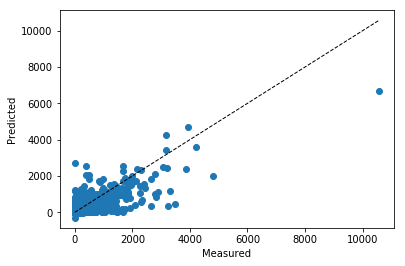

In [12]:
# Let's compare graphically the predicted and actual values
fig, ax = plt.subplots()
ax.scatter(target, predicted)
ax.plot([target.min(), target.max()], [target.min(), target.max()], 'k--', lw=1)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
plt.show()

It's quite difficult to visually assess the performance of our model, but the main trend is toward the first bisector which is a good sign.

It also looks like there is an outlier we forgot to remove here (dot on the right up side of the graph). 

<a id='in_sample_error'></a>
## In-Sample Error and Estimated Coefficients
Let's now train on our entire dataset and have a look at the estimated coefficients to get the patterns the model detected.

In [13]:
# Let's train on all data 
lin_reg=linear_model.LinearRegression()
mod1=lin_reg.fit(features[subset_features],target)

In [14]:
# In-sample error
from sklearn.metrics import mean_absolute_error
-metrics.mean_absolute_error(target,mod1.predict(features[subset_features]))

-56.600083327149065

Remind that it is usual to have a smaller in-sample error as the output data we are comparing our forecasts with has been used to train the model.

For the estimated coefficients we should in theory have a look at the __p-values__ - statistic values that indicate whether our estimated coefficient is significantly different from zero. We won't go more into details here. 

In [15]:
# Let's have a look at the estimated coefficients
coef1=pd.DataFrame(
    {'feature': list(features[subset_features].columns),
     'coefficient': list(mod1.coef_)
    })
coef1.sort_values(by='coefficient', ascending=False).reset_index(drop=True).head(5)

,coefficient,feature
0,6.541515,most_weekday_weekday_2
1,4.831388,most_genre_Sport
2,3.625429,most_genre_Drama
3,2.676683,most_timeday_Afternoon
4,2.654163,most_genre_News


In [16]:
coef1.sort_values(by='coefficient', ascending=False).reset_index(drop=True).tail(5)

,coefficient,feature
29,-6.872885,most_genre_Music
30,-7.023103,most_timeday_Evening
31,-8.022035,most_timeday_Night
32,-9.211985,most_weekday_weekday_0
33,-16.821276,most_genre_Children's


The results are quite interesting here. It seems that some particular habits __drive__ the amount of content consumed. User that consume content on iPlayer most of the time on Wednesdays, or in the afternoon, or whose favourite genre is News are likely to consume more content (positive coefficients). On the other side, users whose favourite genre is Children's won't consume - in terms of total of minutes - much. It's difficult to speak of drivers for _engagement_ here because the minutes watched is highly correlated to the type of content. Children's pieces of content are on average shorter than Sport or Drama ones. It doesn't mean than the user's who consume only Children's content are less engaged. 

The estimated coefficients can be interpreted as follow: for the `num_genre` variable, the estimated contribution is 1,3. All other thing being equal (favourite genre "Drama", favourite time of the day "Evening" etc.), consuming one other genre in the past weeks will make the user consume 1,3mn more within the two following weeks. While this is certainly a bit far-fetched, looking at the sign of the coefficient is a good sanity check. For example we won't expect the number of different genre consumed to lower engagement.

We also have to bare in mind that we didn't check the _p-values_ here and that the coefficients could not be significant.

<a id='ridge_reg'></a>
# Ridge Regression

__DETAILS __

`scikit documentation`: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

<a id='model_training2'></a>
## Model Training and Hyperparameters Tuning

We need to tune the penalty parameter _alpha_. Let's have the same approach than for the classification part and do a grid search.

In [ ]:
# Setup the model and develop a simple grid search against some key parameters
param_alpha=[0.001,0.01,0.1,1.0,10,100]

In [ ]:
# Let's keep track of our best parameters
best_score=-200
best_param=0

# we will setup a manual grid search, but you can also use the gridsearchCV capability in sklearn
for i in param_alpha:
    reg_r = linear_model.Ridge(alpha = i)
    scores=cross_val_score(reg_r,
                           features,
                           target,
                           scoring='neg_mean_absolute_error')
    if np.mean(scores)>best_score:
        best_score=np.mean(scores)
        best_param=i

# print the overall best results
print('Best Settings: alpha:',best_param)
print('Score:', best_score)

__COMMENTS__

<a id='best_ridge_reg'></a>
## Best Ridge Regression

In [ ]:
# Let's keep our best model (hyperparameters tuned)
ridge=linear_model.Ridge(alpha = best_param)
mod2=ridge.fit(features,target)

In [ ]:
# In-sample error
-metrics.mean_absolute_error(target,mod2.predict(features))

In [ ]:
# Let's compare graphically the predicted and actual values
fig, ax = plt.subplots()
ax.scatter(target, mod2.predict(features))
ax.plot([target.min(), target.max()], [target.min(), target.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

__COMMENTS__

<a id='lasso_reg'></a>
# Lasso Regression

__DETAILS __

`scikit documentation`: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

<a id='model_training3'></a>
## Model Training and Hyperparameters Tuning

Again we need to tune the penalty parameter _alpha_.

In [ ]:
# Setup the model and develop a simple grid search against some key parameters
param_alpha=[0.001,0.01,0.1,1.0,10,100]

In [ ]:
# Let's keep track of our best parameters
best_score=-200
best_param=0

# we will setup a manual grid search, but you can also use the gridsearchCV capability in sklearn
for i in param_alpha:
    reg_r = linear_model.LassoLars(alpha = i)
    scores=cross_val_score(reg_r,
                           features,
                           target,
                           scoring='neg_mean_absolute_error')
    if np.mean(scores)>best_score:
        best_score=np.mean(scores)
        best_param=i

# print the overall best results
print('Best Settings: alpha:',best_param)
print('Score:', best_score)

__COMMENTS__

<a id='best_lasso_reg'></a>
## Best Lasso Regression

In [ ]:
# Let's keep our best model (hyperparameters tuned)
lasso=linear_model.LassoLars(alpha = best_param)
mod3=lasso.fit(features,target)

In [ ]:
# In-sample error
-metrics.mean_absolute_error(target,mod3.predict(features))

In [ ]:
# Let's compare graphically the predicted and actual values
fig, ax = plt.subplots()
ax.scatter(target, mod3.predict(features))
ax.plot([target.min(), target.max()], [target.min(), target.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

__COMMENTS__

<a id='combine'></a>
# Combine the Regression and Classification Models
and generate an overall score 
